In [ ]:
# We have to force re-install librosa; otherwise there might be issues with some dependencies
!pip install --force-reinstall librosa

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import librosa
import numpy as np
import os
from moviepy.editor import AudioFileClip
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [3]:
# Let us download data of speech segments with emotion annotation
# Specifically, we are using the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)
# It is available here: https://zenodo.org/records/1188976
# There are both speech files and song files; we only use the speech files (the audio-only files)
# We will have 1440 files: 60 trials per actor x 24 actors = 1440

!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip

--2023-11-21 14:33:47--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1188976/files/Audio_Speech_Actors_01-24.zip [following]
--2023-11-21 14:33:47--  https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip.4’

Audio_Speech_Actors 100%[===================>] 198.81M  30.4MB/s    in 7.4s    

2023-11-21 14:33:55 (26.8 MB/s) - ‘Audio_Speech_Actors_01-24.zip.4’ saved [208468073/208468073]



In [4]:
!unzip Audio_Speech_Actors_01-24.zip

Archive:  Audio_Speech_Actors_01-24.zip
replace Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
# Function to extract MFCCs from an audio file
def extract_mfccs(file_path, n_mfcc=13):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed

# Directory where the RAVDESS data is stored
data_dir = '/content/'  # Update with your path
actor_folder_list = [i for i in os.listdir(data_dir) if 'Actor' in i]
actor_folder_list = sorted([i for i in actor_folder_list if i != 'Audio_Speech_Actors_01-24.zip'])

In [6]:
# We can listen to one of the clips
# If you want to listen to other clips, you can change the last index when defining the ex_file (e.g., choose 2 instead of 1)
ex_file = os.path.join(os.path.join(data_dir, actor_folder_list[0]), os.listdir(os.path.join(data_dir, actor_folder_list[0]))[1])
print(ex_file)
y_ex, sr_ex = librosa.load(ex_file, sr=None)
ipd.display(ipd.Audio(data=y_ex, rate=sr_ex))

/content/Actor_01/03-01-03-01-02-02-01.wav


In [7]:
# Load dataset and extract features
features = []
labels = []
raw_waves = []

# Iterate over all actors
for actor in actor_folder_list:
    actor_dir = os.path.join(data_dir, actor)
    if os.path.isdir(actor_dir):
        # Iterate over all audio files for the actor
        for file_name in sorted(os.listdir(actor_dir)):
            file_path = os.path.join(actor_dir, file_name)
            # Load the raw sound wave
            raw_wave, sample_rate = librosa.load(file_path, sr=None) # Set 'sr=None' to keep original sample rate
            raw_waves.append(raw_wave)
            # Extract MFCCs
            mfccs = extract_mfccs(file_path)
            features.append(mfccs)
            # The emotion label is the third number in the file name split by '-'
            emotion_code = int(file_name.split('-')[2])
            labels.append(emotion_code)

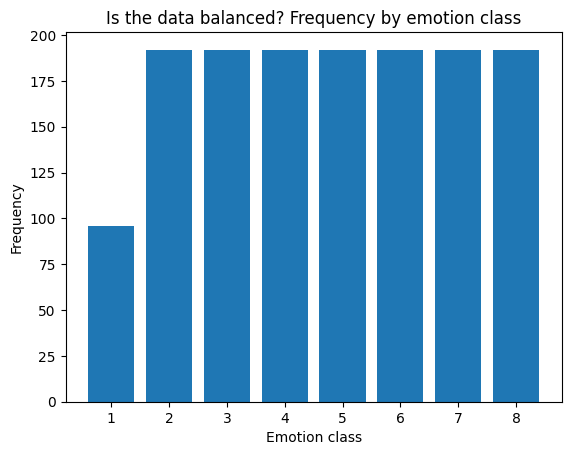

In [8]:
# Let us check if the different classes come with similar frequencies

unique, counts = np.unique(labels, return_counts=True)

plt.bar(unique, counts)
plt.title('Is the data balanced? Frequency by emotion class')
plt.xlabel('Emotion class')
plt.ylabel('Frequency')
plt.xticks(unique)
plt.show()

In [9]:
# Let us double-check the dimension of the data (recall that we should have 1440 data points)
print("Number of obs:", len(features))
print("Number of features:", len(features[0]))

print("Length of raw waves (example 1):", len(raw_waves[0]))
print("Length of raw waves (example 2):", len(raw_waves[1]))
print("Length of raw waves (example 3):", len(raw_waves[2]))
print("Length of raw waves (example 4):", len(raw_waves[3]))

Number of obs: 1440
Number of features: 13
Length of raw waves (example 1): 158558
Length of raw waves (example 2): 160160
Length of raw waves (example 3): 156956
Length of raw waves (example 4): 152152


In [10]:
# Which objects can we easily convert to numpy arrays?
features = np.array(features) # Contains the MFCCs
labels = np.array(labels) # Contains the emotion labels

# What should we do with the raw waves?

In [11]:
# Simple fixes are truncating all clips to the shortest clip's length...
# ... or padding all clips to the longest clip's length

# Let us check out the minimum and maximum length
min_length = min(len(wave) for wave in raw_waves)
max_length = max(len(wave) for wave in raw_waves)

print("Min. length of raw waves:", min_length)
print("Max. length of raw waves:", max_length)

Min. length of raw waves: 140941
Max. length of raw waves: 253053


In [12]:
raw_waves_pad = np.zeros((len(raw_waves), max_length))

for i, wave in enumerate(raw_waves):
    # Ensure wave is a numpy array with the correct type
    wave_array = np.array(wave, dtype=raw_waves_pad.dtype)
    # Copy the wave into the beginning of the padded array
    raw_waves_pad[i, :len(wave_array)] = wave_array

In [13]:
# We can listen to a padded sound wave
ipd.display(ipd.Audio(data=raw_waves_pad[0], rate=sr_ex))

In [14]:
# Double-check the dimensions
print(type(raw_waves_pad))
print(raw_waves_pad.shape)

<class 'numpy.ndarray'>
(1440, 253053)


In [15]:
# Let us run a SVM with the MFCC features
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=123)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Support Vector Classifier
svm_model = SVC(kernel='linear')

# Fit the model on the training data
svm_model.fit(X_train_scaled, y_train)

# Predict emotions on the test set
y_pred = svm_model.predict(X_test_scaled)

# Calculate the accuracy and print the classification report
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy', accuracy)
print(classification_report(y_test, y_pred))

Accuracy 0.4305555555555556
              precision    recall  f1-score   support

           1       0.25      0.04      0.07        24
           2       0.34      0.57      0.43        42
           3       0.40      0.40      0.40        52
           4       0.25      0.26      0.25        47
           5       0.65      0.63      0.64        52
           6       0.42      0.49      0.45        39
           7       0.54      0.45      0.49        56
           8       0.45      0.42      0.43        48

    accuracy                           0.43       360
   macro avg       0.41      0.41      0.40       360
weighted avg       0.43      0.43      0.42       360



In [16]:
# Are you happy with the accuracy?
# What would be the accuracy for random guessing here?
# For one class, precision and recall are relatively high
# Which emotion could it reflect?
# Hint: check the labels in the data documentation here https://zenodo.org/records/1188976

In [17]:
# Now, for comparison, what would happen if we fed the padded raw waves to the SVM?
# To actually run this code, you will have to change run_all to False
# (You will see in a second why this is helpful ;))

run_all = True

if run_all == False:
  # Split the data into training and testing sets
  X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(raw_waves_pad, labels, test_size=0.25, random_state=123)

  # Standardize features by removing the mean and scaling to unit variance
  scaler = StandardScaler()
  X_train_raw_scaled = scaler.fit_transform(X_train_raw)
  X_test_raw_scaled = scaler.transform(X_test_raw)

  # Initialize the Support Vector Classifier
  svm_model_raw = SVC(kernel='linear')

  # Fit the model on the training data
  svm_model_raw.fit(X_train_raw_scaled, y_train_raw)

  # Predict emotions on the test set
  y_pred_raw = svm_model_raw.predict(X_test_raw_scaled)

  # Calculate the accuracy and print the classification report
  accuracy_raw = accuracy_score(y_test_raw, y_pred_raw)
  print('Accuracy using raw waves:', accuracy_raw)
  print(classification_report(y_test_raw, y_pred_raw))

In [18]:
# Let us try if it helps to downsample
# Usually, we downsample *before* padding

sr_new = 8000  # For example, we can downsample to 8kHz

raw_waves_down = []

# Downsample the raw waves
for wave in raw_waves:
    # Use librosa to resample the wave
    wave_downsampled = librosa.resample(wave, orig_sr=sr_ex, target_sr=sr_new)
    raw_waves_down.append(wave_downsampled)

# Get the maximum wave length after downsampling
max_length_down = max(len(wave) for wave in raw_waves_down)
print("Downsampled maximum wave length:", max_length_down)

# Pad the downsampled waves

raw_waves_down_pad = np.zeros((len(raw_waves_down), max_length_down))

for i, wave in enumerate(raw_waves_down):
    # Ensure wave is a numpy array with the correct type
    wave_array = np.array(wave, dtype=raw_waves_down_pad.dtype)
    # Copy the wave into the beginning of the padded array
    raw_waves_down_pad[i, :len(wave_array)] = wave_array

Downsampled maximum wave length: 42176


In [19]:
# How does a downsampled, padded wave sound?
ipd.display(ipd.Audio(data=raw_waves_down_pad[0], rate=sr_new))

In [20]:
# Can we run the SVM now?

# Split the data into training and testing sets (here we have to replace the raw_waves_pad object by raw_waves_down_pad)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(raw_waves_down_pad, labels, test_size=0.25, random_state=123)

# Standardize features by removing the mean and scaling to unit variance
# (For convenience, we will overwrite X_train_raw_scaled, etc.)
scaler = StandardScaler()
X_train_raw_scaled = scaler.fit_transform(X_train_raw)
X_test_raw_scaled = scaler.transform(X_test_raw)

# Initialize the Support Vector Classifier
svm_model_raw = SVC(kernel='linear')

# Fit the model on the training data
svm_model_raw.fit(X_train_raw_scaled, y_train_raw)

# Predict emotions on the test set
y_pred_raw = svm_model_raw.predict(X_test_raw_scaled)

# Calculate the accuracy and print the classification report
accuracy_raw = accuracy_score(y_test_raw, y_pred_raw)
print('Accuracy using raw waves:', accuracy_raw)
print(classification_report(y_test_raw, y_pred_raw))


Accuracy using raw waves: 0.17222222222222222
              precision    recall  f1-score   support

           1       0.11      0.17      0.14        24
           2       0.16      0.55      0.24        42
           3       0.25      0.10      0.14        52
           4       0.14      0.19      0.16        47
           5       0.44      0.08      0.13        52
           6       0.19      0.13      0.15        39
           7       0.17      0.09      0.12        56
           8       0.26      0.15      0.19        48

    accuracy                           0.17       360
   macro avg       0.22      0.18      0.16       360
weighted avg       0.23      0.17      0.16       360



In [21]:
# What do you conclude from this comparison? In terms of computation time? Accuracy?

In [23]:
# What if we used the raw data in a neural network?

# First, we must one-hot encode the labels
y_train_raw_enc = to_categorical(y_train_raw)
y_test_raw_enc = to_categorical(y_test_raw)

# Set up a neural network model with dropout for regularization
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_raw_scaled.shape[1],)),
    Dropout(0.5),  # Add dropout with a 50% rate
    Dense(64, activation='relu'),
    Dropout(0.5),  # Add another dropout layer with a 50% rate
    Dense(y_train_raw_enc.shape[1], activation='softmax')  # Output layer
])

# Compile the model
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
nn_model.fit(X_train_raw_scaled, y_train_raw_enc, epochs=10, batch_size=32)

# Predict emotions on the test set
y_pred_nn = nn_model.predict(X_test_raw_scaled)
y_pred_nn_classes = y_pred_nn.argmax(axis=1)

# Calculate the accuracy and print the classification report
accuracy_nn = accuracy_score(y_test_raw, y_pred_nn_classes)
print('Accuracy using neural network:', accuracy_nn)
print(classification_report(y_test_raw, y_pred_nn_classes))


Epoch 1/10
34/34 [==============================] - 4s 75ms/step - loss: 10.5457 - accuracy: 0.1269
Epoch 2/10
34/34 [==============================] - 3s 100ms/step - loss: 9.0111 - accuracy: 0.1981
Epoch 3/10
34/34 [==============================] - 4s 104ms/step - loss: 5.7744 - accuracy: 0.2343
Epoch 4/10
34/34 [==============================] - 5s 139ms/step - loss: 11.0613 - accuracy: 0.2333
Epoch 5/10
34/34 [==============================] - 3s 99ms/step - loss: 9.0191 - accuracy: 0.2556
Epoch 6/10
34/34 [==============================] - 3s 85ms/step - loss: 7.6563 - accuracy: 0.2778
Epoch 7/10
34/34 [==============================] - 2s 67ms/step - loss: 5.9621 - accuracy: 0.3222
Epoch 8/10
34/34 [==============================] - 2s 70ms/step - loss: 4.9435 - accuracy: 0.3324
Epoch 9/10
34/34 [==============================] - 3s 85ms/step - loss: 3.7397 - accuracy: 0.3611
Epoch 10/10
12/12 [==============================] - 1s 32ms/step
Accuracy using neural network: 0.19166

In [24]:
# What if we run a CNN?

# What if we used the raw data in a neural network?

# First, we must one-hot encode the labels
y_train_raw_enc = to_categorical(y_train_raw)
y_test_raw_enc = to_categorical(y_test_raw)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.layers import Conv1D, Flatten

# Assuming X_train_raw_scaled is a 2D numpy array (samples x features)
nn_model = Sequential([
    # First convolutional layer
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_raw_scaled.shape[1], 1)),
    Dropout(0.5),
    # Second convolutional layer
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Dropout(0.5),
    # Flatten the output to feed it into a dense layer
    Flatten(),
    # Dense layer
    Dense(64, activation='relu'),
    # Output layer
    Dense(y_train_raw_enc.shape[1], activation='softmax')
])

# Compile the model
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
nn_model.fit(X_train_raw_scaled, y_train_raw_enc, epochs=5, batch_size=32)

# Predict emotions on the test set
y_pred_nn = nn_model.predict(X_test_raw_scaled)
y_pred_nn_classes = y_pred_nn.argmax(axis=1)

# Calculate the accuracy and print the classification report
accuracy_nn = accuracy_score(y_test_raw, y_pred_nn_classes)
print('Accuracy using neural network:', accuracy_nn)
print(classification_report(y_test_raw, y_pred_nn_classes))


Epoch 1/5
34/34 [==============================] - 225s 6s/step - loss: 5.7573 - accuracy: 0.1806
Epoch 2/5
34/34 [==============================] - 210s 6s/step - loss: 1.8193 - accuracy: 0.3380
Epoch 3/5
34/34 [==============================] - 210s 6s/step - loss: 1.5659 - accuracy: 0.4481
Epoch 4/5
34/34 [==============================] - 218s 6s/step - loss: 1.2512 - accuracy: 0.5704
Epoch 5/5
12/12 [==============================] - 14s 1s/step
Accuracy using neural network: 0.35
              precision    recall  f1-score   support

           1       0.33      0.12      0.18        24
           2       0.40      0.52      0.45        42
           3       0.29      0.12      0.16        52
           4       0.25      0.55      0.34        47
           5       0.58      0.42      0.49        52
           6       0.23      0.26      0.24        39
           7       0.40      0.48      0.44        56
           8       0.50      0.21      0.29        48

    accuracy         

In [25]:
# Does the neural net help? You can play a bit with the set-up of the model (remove a layer, add a layer)... add or remove epochs...
# What else could we try (possibly beyond the scope of this tutorial)?
# Do you think we could improve the perfomance if we had more data?
# If we do not have more data, how could we "create" more?

In [26]:
# For completeness, let us check the performance of the neural net with the MFCC
# Note that the neural net is simpler now (why can this make sense?)

nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(y_train_raw_enc.shape[1], activation='softmax')  # Output layer
])

# Compile the model
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
nn_model.fit(X_train, y_train_raw_enc, epochs=10, batch_size=32)

# Predict emotions on the test set
y_pred_nn = nn_model.predict(X_test)
y_pred_nn_classes = y_pred_nn.argmax(axis=1)

# Calculate the accuracy and print the classification report
accuracy_nn = accuracy_score(y_test, y_pred_nn_classes)
print('Accuracy using neural network:', accuracy_nn)
print(classification_report(y_test, y_pred_nn_classes))


Epoch 1/10
34/34 [==============================] - 1s 3ms/step - loss: 86.2151 - accuracy: 0.1037
Epoch 2/10
34/34 [==============================] - 0s 3ms/step - loss: 59.7822 - accuracy: 0.1472
Epoch 3/10
34/34 [==============================] - 0s 3ms/step - loss: 47.8383 - accuracy: 0.1324
Epoch 4/10
34/34 [==============================] - 0s 3ms/step - loss: 33.9773 - accuracy: 0.1444
Epoch 5/10
34/34 [==============================] - 0s 3ms/step - loss: 25.1641 - accuracy: 0.1426
Epoch 6/10
34/34 [==============================] - 0s 3ms/step - loss: 16.6169 - accuracy: 0.1546
Epoch 7/10
34/34 [==============================] - 0s 3ms/step - loss: 10.8944 - accuracy: 0.1685
Epoch 8/10
34/34 [==============================] - 0s 3ms/step - loss: 6.7072 - accuracy: 0.1778
Epoch 9/10
34/34 [==============================] - 0s 4ms/step - loss: 4.0023 - accuracy: 0.1880
Epoch 10/10
12/12 [==============================] - 0s 2ms/step


  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))



Accuracy using neural network: 0.25277777777777777
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        24
           2       0.22      0.43      0.29        42
           3       0.27      0.46      0.34        52
           4       0.40      0.17      0.24        47
           5       0.50      0.31      0.38        52
           6       0.27      0.31      0.29        39
           7       0.18      0.05      0.08        56
           8       0.13      0.21      0.16        48

    accuracy                           0.25       360
   macro avg       0.25      0.24      0.22       360
weighted avg       0.26      0.25      0.23       360



In [27]:
# Let us try to extract more meaningful features from the audio data

# Let us use some spectral features
# - Spectral contrast: gives the difference in amplitude between peaks and valleys in the sound spectrum
# Spectral centroid, spectral bandwith, and spectral flatness: see lecture slides
# Energy: The sum of squares of the signal values, normalized by the respective frame length
# Entropy of energy: the entropy of normalized energy (to indicate abrupt changes)

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    S, phase = librosa.magphase(librosa.stft(y))
    contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    flatness = librosa.feature.spectral_flatness(y=y)
    rms = librosa.feature.rms(y=y)
    energy = np.sum(rms)
    entropy = -np.sum(rms * np.log2(rms + 1e-6))  # Added a small constant to avoid log(0)
    # Since these are 2D arrays, we take the mean (or the sum) to get a single value per feature
    # That is, time and the value for each time
    # For machine learning models, we typcially want fixed-length features
    # Hence, we average these time-varying features
    features = np.concatenate((np.mean(contrast, axis=1),
                               np.mean(centroid, axis=1),
                               np.mean(bandwidth, axis=1),
                               np.mean(flatness, axis=1),
                               [energy],
                               [entropy]), axis=0)
    return features

# Initialize feature and label lists
features_spec = []

# For the labels, since we sorted the directory, we can use the same "labels" object as before

# Iterate over all actors and files to extract features
for actor in actor_folder_list:
    actor_dir = os.path.join(data_dir, actor)
    if os.path.isdir(actor_dir):
        for file_name in sorted(os.listdir(actor_dir)):
            file_path = os.path.join(actor_dir, file_name)
            # Extract features_spec and add them to the list
            file_features = extract_features(file_path)
            features_spec.append(file_features)

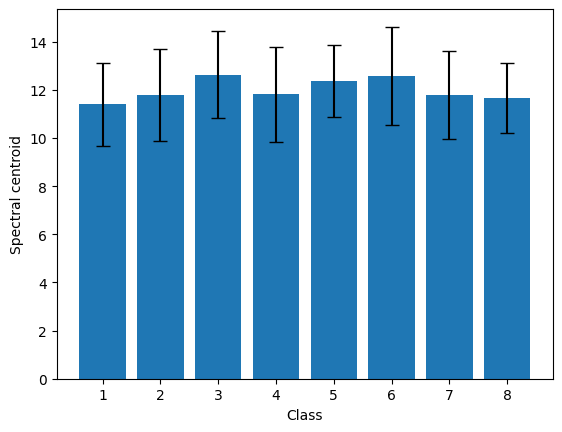

In [28]:
# We can explore these features

# Define a function that plots the feature's average with error bars by class
def plot_feature_averages(features, labels, feature_index, feature_name):
    # Extract the feature from the features based on the given index
    feature_values = np.array(features)[:, feature_index]
    # Calculate the average and standard deviation for each class
    class_labels = np.unique(labels)
    average_values = []
    std_dev_values = []
    for label in class_labels:
        indices = np.where(labels == label)
        class_features = feature_values[indices]
        average_values.append(np.mean(class_features))
        std_dev_values.append(np.std(class_features))
    # Plot the average feature values for each class with error bars
    plt.bar(class_labels, average_values, yerr=std_dev_values, capsize=5)
    plt.xlabel('Class')
    plt.ylabel(feature_name)
    plt.show()

# For instance, to explore the spectral centroid, run the function like this
plot_feature_averages(features_spec, labels, 1, 'Spectral centroid')

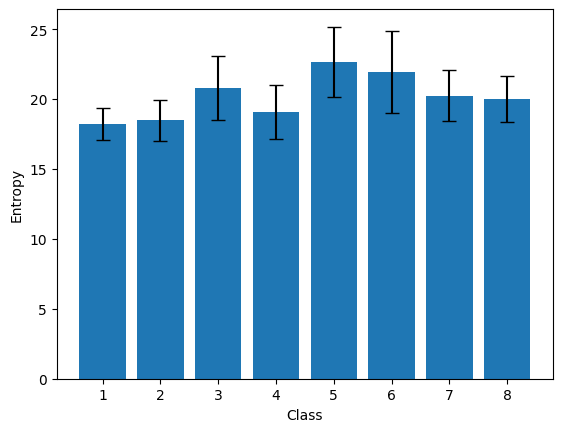

In [29]:
# For other features,  replace 1 with the index of the desired feature
# For the entropy, let us run this:
plot_feature_averages(features_spec, labels, 6, 'Entropy')

# Or plot them all
# for i in [0,1,2,3,4,5,6]:
#  plot_feature_averages(features_spec, labels, i, '')

In [30]:
# Convert the spectral features and friends to an array
features_spec = np.array(features_spec)

In [31]:
# Let us concatenate the MFCC features and the spectral features (and friends)

# Concatenate the features and spectral features along the feature axis
combined_features = np.concatenate((features, features_spec), axis=1)

# Split the data into training and testing sets using the combined features
X_train_spec, X_test_spec, y_train_spec, y_test_spec = train_test_split(combined_features, labels, test_size=0.25, random_state=123)

# Standardize the combined features by removing the mean and scaling to unit variance
scaler_spec = StandardScaler()
X_train_spec_scaled = scaler_spec.fit_transform(X_train_spec)
X_test_spec_scaled = scaler_spec.transform(X_test_spec)

# Initialize the Support Vector Classifier
svm_model_spec = SVC(kernel='linear')

# Fit the model on the training data
svm_model_spec.fit(X_train_spec_scaled, y_train_spec)

# Predict emotions on the test set
y_pred_spec = svm_model_spec.predict(X_test_spec_scaled)

# Calculate the accuracy and print the classification report
accuracy_spec = accuracy_score(y_test_spec, y_pred_spec)
print('Accuracy with combined features:', accuracy_spec)
print(classification_report(y_test_spec, y_pred_spec))


Accuracy with combined features: 0.5083333333333333
              precision    recall  f1-score   support

           1       0.15      0.08      0.11        24
           2       0.50      0.67      0.57        42
           3       0.41      0.42      0.42        52
           4       0.42      0.38      0.40        47
           5       0.77      0.63      0.69        52
           6       0.45      0.62      0.52        39
           7       0.54      0.57      0.56        56
           8       0.62      0.50      0.55        48

    accuracy                           0.51       360
   macro avg       0.48      0.48      0.48       360
weighted avg       0.51      0.51      0.50       360



In [32]:
# What do you conclude? # How would you approach this task in a more comprehensive setting?